In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
class WildlifeDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = {species: idx for idx, species in enumerate(species_paths.keys())}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = os.path.basename(os.path.dirname(image_path))
        
        # Convert label to integer index
        label_idx = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label_idx  # Return integer label instead of string

In [4]:
# Define the paths
species_paths = {
    "bald_eagle": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\bald_eagle",
    "black_bear": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\black_bear",
    "bobcat": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\bobcat",
    "cheetah": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\cheetah",
    "cougar": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\cougar",
    "deer": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\deer",
    "elk": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\elk",
    "Horse": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\Horse",
    "hyena": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\hyena",
    "lion": r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\lion"
}

# Collect all image paths and labels
image_paths = []
labels = []
for species, path in species_paths.items():
    species_images = [os.path.join(path, img) for img in os.listdir(path)]
    image_paths.extend(species_images)
    labels.extend([species] * len(species_images))

# Split the data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = WildlifeDataset(train_paths, transform=transform)
val_dataset = WildlifeDataset(val_paths, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
#Define the CNN Model
class WildlifeCNN(nn.Module):
    def __init__(self, num_classes):
        super(WildlifeCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model
num_classes = len(species_paths)
model = WildlifeCNN(num_classes)

C:\Users\Shashank S M\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shashank S M\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#Train the Model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# Save the model
torch.save(model.state_dict(), "wildlife_best_model.pth")

C:\Users\Shashank S M\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 0.6443917141719298
Epoch [2/10], Loss: 0.272646422348135
Epoch [3/10], Loss: 0.21320111410028034
Epoch [4/10], Loss: 0.1563632354283562
Epoch [5/10], Loss: 0.1120354241343098
Epoch [6/10], Loss: 0.1380399413686897
Epoch [7/10], Loss: 0.07748065445038092
Epoch [8/10], Loss: 0.05414828412329218
Epoch [9/10], Loss: 0.07476727436524588
Epoch [10/10], Loss: 0.13128271392527055


In [7]:
#Evaluate the Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on validation set: {100 * correct / total}%")

Accuracy on validation set: 90.19264448336253%


In [74]:
# pip install torch torchvision matplotlib pillow
# Define class_to_idx and idx_to_class mappings
class_to_idx = {species: idx for idx, species in enumerate(species_paths.keys())}
idx_to_class = {idx: species for species, idx in class_to_idx.items()}

# Load the pre-trained model
model.load_state_dict(torch.load("wildlife_best_model.pth", weights_only=True))  # Use weights_only=True for security
model.eval()

# Function to predict species
def predict_species(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted_idx = torch.max(output, 1)
        return idx_to_class[predicted_idx.item()]

# Example prediction
image_path = r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\black_bear\0a8eaec98cc2542440.jpg"
predicted_species = predict_species(image_path)
print(f"Predicted Species: {predicted_species}")

Predicted Species: black_bear


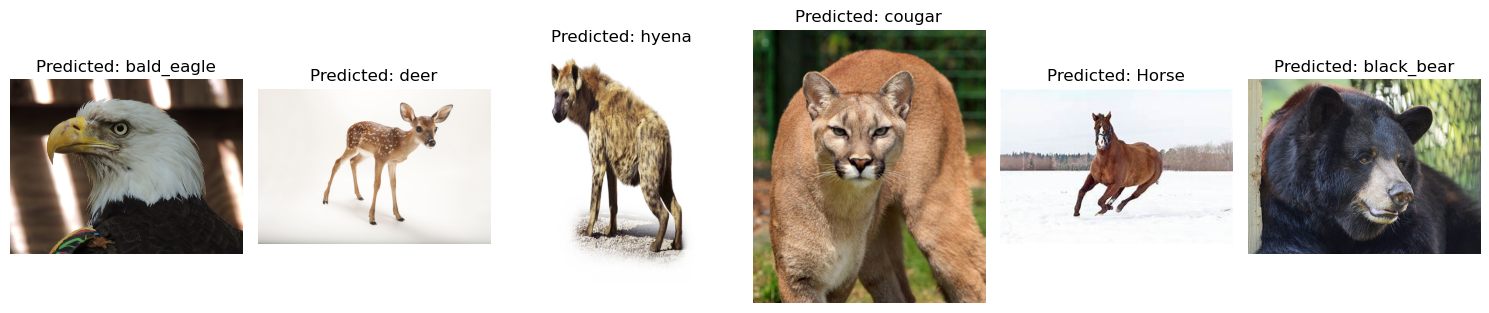

In [72]:
# Function to predict species for a single image
def predict_species(image_path):
    # Open and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Make prediction
    with torch.no_grad():
        output = model(input_image)
        _, predicted_idx = torch.max(output, 1)
        predicted_species = idx_to_class[predicted_idx.item()]
    
    return image, predicted_species

# Function to predict species for multiple images
def predict_multiple_images(image_paths):
    # Create a figure to display all images
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figure size as needed
    
    # If only one image is provided, axes will not be a list
    if num_images == 1:
        axes = [axes]
    
    # Process each image
    for i, image_path in enumerate(image_paths):
        # Predict species
        image, predicted_species = predict_species(image_path)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted: {predicted_species}")
        axes[i].axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

# Example: Predict species for multiple images
image_paths = [
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\bald_eagle\00e148aeea989ba56b.JPG",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\deer\1d3c8b41f41d65644f.JPG",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\hyena\00000033_512resized.png",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\cougar\0d2007f4298d62f48f.jpeg",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\Horse\OIP-_CiE3X1jze8pK1bWjiF4WwHaE8.jpeg",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\black_bear\0a8eaec98cc2542440.jpg"
]

# Call the function to predict and display results
predict_multiple_images(image_paths)

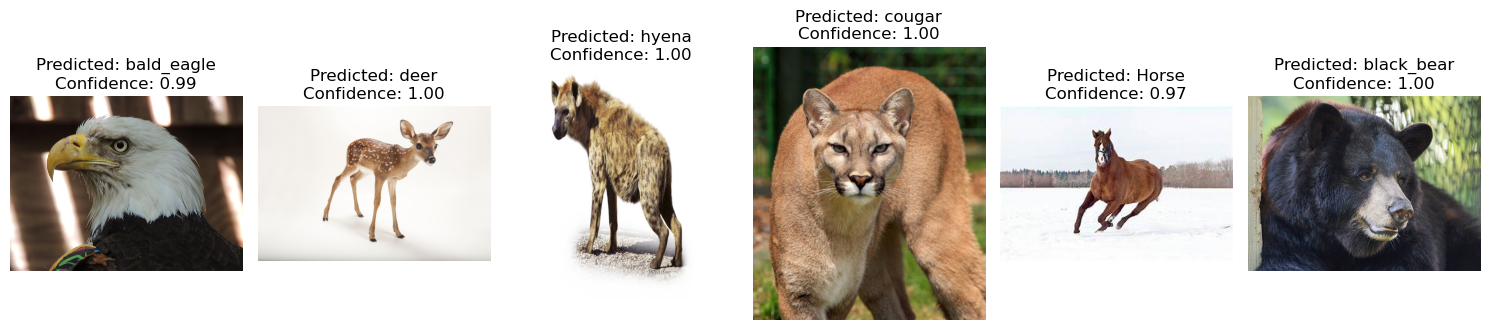

In [70]:
import torch.nn.functional as F

# Function to predict species with confidence score
def predict_species_with_confidence(image_path):
    # Open and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Make prediction
    with torch.no_grad():
        output = model(input_image)
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
        confidence, predicted_idx = torch.max(probabilities, 1)
        predicted_species = idx_to_class[predicted_idx.item()]
        confidence_score = confidence.item()  # Confidence score
    
    return image, predicted_species, confidence_score

# Function to predict and display multiple images with confidence
def predict_multiple_images_with_confidence(image_paths):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figure size as needed
    
    # If only one image is provided, axes will not be a list
    if num_images == 1:
        axes = [axes]
    
    # Process each image
    for i, image_path in enumerate(image_paths):
        # Predict species with confidence
        image, predicted_species, confidence_score = predict_species_with_confidence(image_path)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted: {predicted_species}\nConfidence: {confidence_score:.2f}")
        axes[i].axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

# Example: Predict species for multiple images with confidence
image_paths = [
     r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\bald_eagle\00e148aeea989ba56b.JPG",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\deer\1d3c8b41f41d65644f.JPG",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\hyena\00000033_512resized.png",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\cougar\0d2007f4298d62f48f.jpeg",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\Horse\OIP-_CiE3X1jze8pK1bWjiF4WwHaE8.jpeg",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\black_bear\0a8eaec98cc2542440.jpg"
]

# Call the function to predict and display results with confidence
predict_multiple_images_with_confidence(image_paths)

In [76]:
import csv
import base64
from PIL import Image
import io

# Function to encode an image to base64
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string

# Function to save predictions to a CSV file with images
def save_predictions_to_csv_with_images(image_paths, predictions, output_file="predictions_with_images.csv"):
    with open(output_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Image Path", "Predicted Species", "Image (Base64)"])  # Write header
        for path, pred in zip(image_paths, predictions):
            # Encode the image to base64
            encoded_image = encode_image_to_base64(path)
            writer.writerow([path, pred, encoded_image])

# Example usage
image_paths = [
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\bald_eagle\00e148aeea989ba56b.JPG",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\deer\1d3c8b41f41d65644f.JPG",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\hyena\00000033_512resized.png",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\cougar\0d2007f4298d62f48f.jpeg",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\Horse\OIP-_CiE3X1jze8pK1bWjiF4WwHaE8.jpeg",
    r"C:\Users\Shashank S M\Desktop\Wildlife_species_identify\Wildlife_animals\Wildlife\black_bear\0a8eaec98cc2542440.jpg"
]

# Get predictions
predictions = [predict_species(path)[1] for path in image_paths]

# Save predictions to CSV with images
save_predictions_to_csv_with_images(image_paths, predictions, output_file="predictions_with_images.csv")
print("Predictions with images saved to predictions_with_images.csv")


Predictions with images saved to predictions_with_images.csv


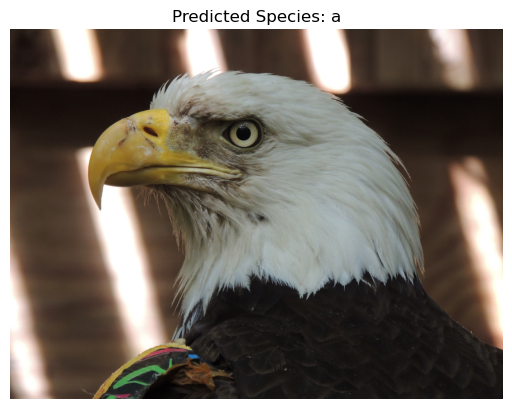

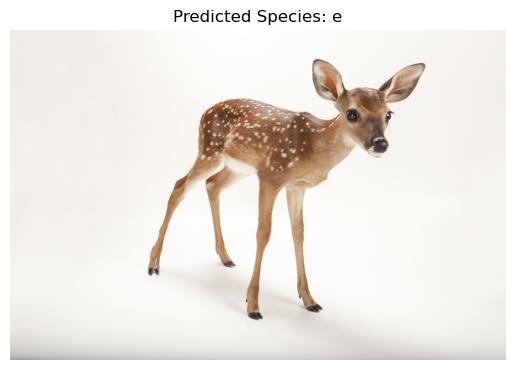

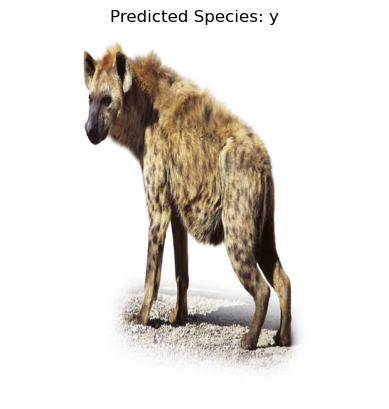

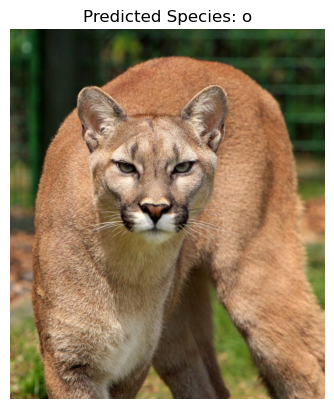

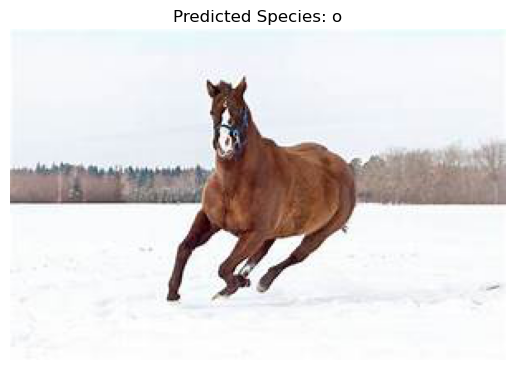

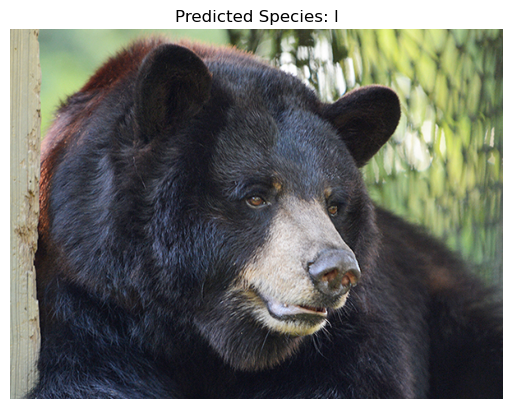

In [78]:
#To view Predicted images which are saved in CSV file
import csv
import base64
from PIL import Image
import io
import matplotlib.pyplot as plt
import sys

# Increase the CSV field size limit
max_int = sys.maxsize
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = int(max_int / 10)

# Function to decode base64 to image
def decode_base64_to_image(encoded_string):
    decoded_image = base64.b64decode(encoded_string)
    image = Image.open(io.BytesIO(decoded_image))
    return image

# Function to display images from the CSV file
def display_images_from_csv(csv_file):
    with open(csv_file, mode="r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            image_path, predicted_species, encoded_image = row
            image = decode_base64_to_image(encoded_image)
            
            # Display the image
            plt.imshow(image)
            plt.title(f"Predicted Species: {predicted_species}")
            plt.axis('off')  # Hide axes
            plt.show()

# Example usage
display_images_from_csv("predictions_with_images.csv")